In [1]:
#--------------- Packages ---------------#
%load_ext autoreload
%autoreload 2
import os
import sys
import torch
import Corrfunc
import numpy as np
from sbi import utils
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
from sbi.inference.base import infer
from colossus.cosmology import cosmology
from scipy.stats import norm, multivariate_normal
from colossus.halo import concentration, profile_nfw, profile_composite
plt.style.use("/global/u2/t/titus/Titus/Lensing/mass_calibration_of_DM_halos/CustomizingPlots")
%matplotlib inline

/global/homes/t/titus/.conda/envs/mass_cal/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
lensing_path = os.path.expanduser("~/Titus/Lensing/mass_calibration_of_DM_halos/mini_uchuu/mini_uchuu_lensing")
sys.path.append(lensing_path)
from measure_lensing_v2 import MeasureLensing
from read_mini_uchuu import ReadMiniUchuu
output_loc = '/global/u2/t/titus/Titus/Lensing/output/'
nbody_loc = '/global/u2/t/titus/Titus/Lensing/data/'
lensing_loc = '/global/u2/t/titus/Titus/Lensing/data/McClintock_data/desy1_tamas/'

z=0.3
rmu = ReadMiniUchuu(nbody_loc, redshift=z)
xp, yp, zp = rmu.read_particles()

#### halos ####
rmu.read_halos(Mmin=1e13)
xh = rmu.xh
yh = rmu.yh
zh = rmu.zh
mass = rmu.mass
boxsize = rmu.boxsize
rhocrit = 2.775e11
OmegaM = rmu.OmegaM
mpart = rhocrit*OmegaM*boxsize**3/len(xp)

ml = MeasureLensing(nbody_loc, Rmin=-2, Rmax=2.3, pimax=100)
ml.write_bin_file()

[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSSE3 but the compiler does not.  Can you try another compiler?


## Mass-richness scaling relation

<!-- ### Packages -->

In [3]:
# Set cosmology
cosmo_params = {'flat': True, 'H0': 67.74, 'Om0': 0.3089, 'Ob0': 0.0486, 'sigma8': 0.8159, 'ns': 0.9667}
cosmology.addCosmology('MiniUchuu', cosmo_params)
cosmo = cosmology.setCosmology('MiniUchuu')
h = cosmo_params['H0']/100
# mass-richness scaling relation
def mrsr(M, M_0, z, sr_type = None, params_path = None):
    if sr_type == "mcclintock": # McClintock, 2019 scaling relation
        # # McClintock, 2019 scaling relation
        # lam_0 = 40 # Pivot richness
        # z_0 = 0.35 # Pivot redshift
        # G_z = -0.30 # Redshift scaling index
        # F_lam = 1.356 # Richness scaling index
        # q_ln_lam = 0.25 #scatter
        
        # Melchior, 2017 scaling relation
        lam_0 = 30 # Pivot richness
        z_0 = 0.5 # Pivot redshift
        G_z = 0.18 # Redshift scaling index
        F_lam = 1.12 # Richness scaling index
        q_ln_lam = 0.25 #scatter
        
        lam0 = lam_0*(M/(M_0*((1+z)/(1+z_0))**G_z))**(1/F_lam)
        lam_noisy1 = norm.rvs(lam0, 0.0)
        
        ln_lam = (np.log(M)-np.log(M_0)-G_z*np.log((1+z)/(1+z_0)))/F_lam + np.log(lam_0)
        ln_lam_noisy = norm.rvs(ln_lam, 0.0)
        lam_noisy2 = np.exp(ln_lam_noisy)
    return lam_noisy1, lam_noisy2

def invert_mrsr(lam, M_0, z):
    # Melchior, 2017 scaling relation
    lam_0 = 30 # Pivot richness
    z_0 = 0.5 # Pivot redshift
    G_z = 0.18 # Redshift scaling index
    F_lam = 1.12 # Richness scaling index
    q_ln_lam = 0.25 #scatter
    avg_M = M_0*((lam/lam_0)**F_lam)*((1+z)/(1+z_0))**G_z
    return avg_M

true_mass = mass#[sel]
lam_noiseless1, lam_noiseless2 = mrsr(true_mass*h, 10**14.371, 0.3, "mcclintock") # Melchior scaling relation
lam_noiseless2

array([85.05043702, 76.7555551 , 73.38685966, ...,  1.29422482,
        1.29422482,  1.29411035])

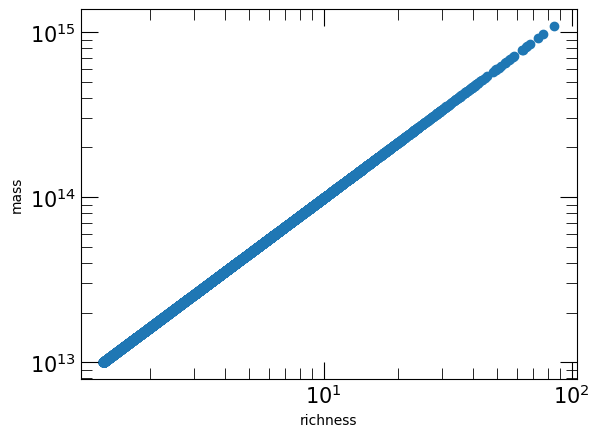

In [4]:
plt.loglog()
# plt.scatter(sel_lam, sel_mass)
plt.scatter(lam_noiseless2, true_mass)
plt.xlabel("richness")
plt.ylabel("mass")
plt.show()

In [5]:
# Creating richness bins
sel0 = (lam_noiseless2 >= 20)&(lam_noiseless2 < 30)
sel1 = (lam_noiseless2 >= 30)&(lam_noiseless2 < 45)
sel2 = (lam_noiseless2 >= 45)&(lam_noiseless2 < 60)
sel3 = lam_noiseless2 >= 60
std_arr_true_nofit = np.array([np.std(np.log10(true_mass[sel0]*h)), np.std(np.log10(true_mass[sel1]*h)), np.std(np.log10(true_mass[sel2]*h)), np.std(np.log10(true_mass[sel3]*h))])
mean_masses_true_nofit = np.array([np.log10(np.mean(true_mass[sel0]*h)), np.log10(np.mean(true_mass[sel1]*h)), np.log10(np.mean(true_mass[sel2]*h)), np.log10(np.mean(true_mass[sel3]*h))])
print(std_arr_true_nofit)
print(mean_masses_true_nofit)

[0.05887089 0.05487138 0.03506692 0.04777322]
[14.25194  14.446058 14.63233  14.773402]


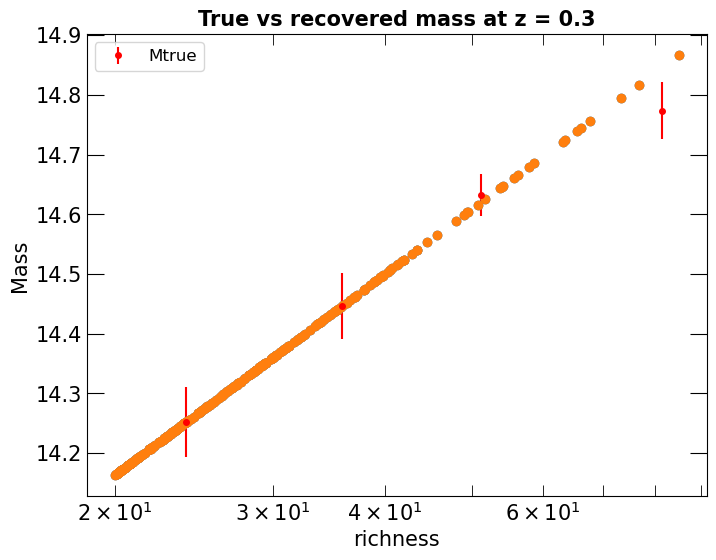

In [8]:
avg_M = invert_mrsr(lam = lam_noiseless2, M_0 = 10**14.371, z = 0.3)
mask = lam_noiseless2 > 20
x = [23.99617, 35.86541, 51.21334, 81.45424]

plt.rcParams['figure.figsize'] = (8,6)
plt.xscale("log")
plt.errorbar(x, mean_masses_true_nofit, yerr = std_arr_true_nofit, 
             fmt = 'o', ms = 4.0, color = 'red',
             label = "Mtrue")
plt.plot(lam_noiseless2[mask], np.log10(true_mass[mask]*h), 'o')
plt.plot(lam_noiseless2[mask], np.log10(avg_M[mask]), 'o')
plt.title("True vs recovered mass at z = 0.3", fontsize=15)
plt.xlabel("richness", fontsize=15)
plt.ylabel("Mass", fontsize=15)
plt.legend()
plt.show()

### Evrard extra term

In [9]:
from sklearn.linear_model import LinearRegression
def evrard_extra_term(richness, mass, C, random_state):#, x_cod, y_cod, z_cod):
    all_mass = norm.rvs(mass, 0.25, random_state=random_state)#mass
    ln_lam0 = richness #norm.rvs(richness, 0.25) #richness
    selection = np.exp(ln_lam0) >= 20
    ln_lam = ln_lam0[selection]
    ln_mass = all_mass[selection] # dependent variable Y
    
    # linear regression model
    lm = LinearRegression() # Construct model
    lm.fit(ln_lam.reshape(-1, 1), ln_mass)
    
    # model parameters
    intercept = lm.intercept_ # the intercept (B).
    slope = lm.coef_ # the slope (A).
    rsquared = lm.score(ln_lam.reshape(-1, 1), ln_mass) # the r-squared value
    reg_line = lm.predict(ln_lam.reshape(-1, 1))
    inv_reg_line = (ln_mass - intercept)/slope
    
    # computing alpha and pi
    alpha = 1/slope
    pi = -alpha*(intercept + C)
    C = - (pi/alpha + intercept)
    log_richness0 = alpha*all_mass + pi #no scatter
    return log_richness0, alpha, pi, C, ln_lam, rsquared, reg_line, ln_mass, selection, all_mass#, x_cod_new, y_cod_new, z_cod_new
    
def evrard_extra_term2(richness, mass, C):
    all_mass = mass
    ln_lam0 = richness #norm.rvs(richness, 0.25) #richness
    selection = np.exp(ln_lam0) >= 20
    ln_lam = ln_lam0[selection]
    ln_mass = all_mass[selection] # dependent variable Y
    
    # linear regression model
    lm = LinearRegression() # Construct model
    lm.fit(ln_lam.reshape(-1, 1), ln_mass)
    
    # model parameters
    intercept = lm.intercept_ # the intercept (B).
    slope = lm.coef_ # the slope (A).
    rsquared = lm.score(ln_lam.reshape(-1, 1), ln_mass) # the r-squared value
    reg_line = lm.predict(ln_lam.reshape(-1, 1))
    inv_reg_line = (ln_mass - intercept)/slope
    
    # computing alpha and pi
    alpha = 1/slope
    pi = -alpha*(intercept + C)
    C = - (pi/alpha + intercept)
    log_richness0 = alpha*all_mass + pi #no scatter
    return log_richness0, alpha, pi, C, ln_lam, rsquared, reg_line, ln_mass, selection#, x_cod_new, y_cod_new, z_cod_new

[4.443243   4.340626   4.295744   ... 0.25791168 0.25791168 0.25782204]
C [2.43913018e-07]
[1.00944823]
[-29.74107182]
rsquared 1.0 

[ 4.7782167   5.21728845  4.71886712 ... -0.31763024 -0.3796058
  0.25399215]


/tmp/ipykernel_1371088/984821074.py:49: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


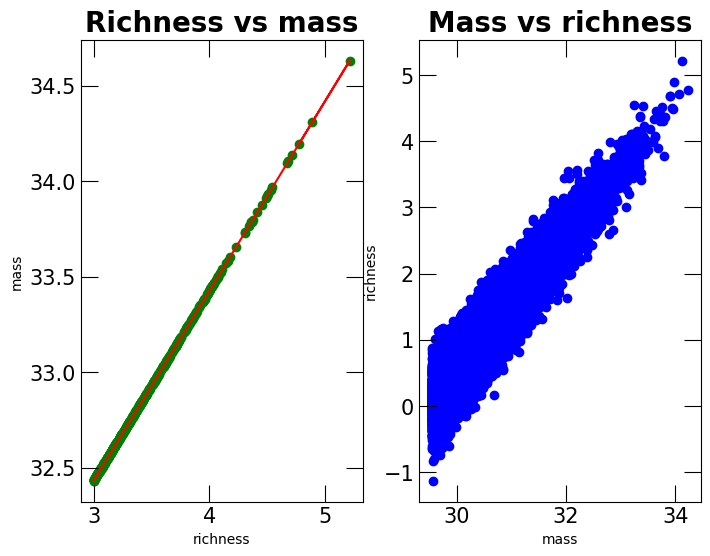

In [10]:
# Melchior, 2017 scaling relation
lam_0 = 30 # Pivot richness
z = 0.30 # redshift
z_0 = 0.5 # Pivot redshift
G_z = 0.18 # Redshift scaling index
F_lam = 1.12 # Richness scaling index
q_ln_lam = 0.25 #scatter
Mpivot = 10**14.371 #pivot mass
M = mass*h#[true_mass>=1e14] # mass

fiducial_C = 0.0 # just a random guess
fiducial_alpha = 1/F_lam
fiducial_pi = -(1/F_lam)*(np.log(Mpivot) + G_z*np.log((1+z)/(1+z_0)) - F_lam*np.log(lam_0))
ln_lam = fiducial_alpha*np.log(M) + fiducial_pi
print(ln_lam)

fiducial_richness = ln_lam #norm.rvs(ln_lam, 0.25) #np.exp(ln_lam)
C_list = [0.0]
M_input = np.log(true_mass*h)

seed = 6
np.random.seed(seed)
random_states = np.random.randint(0, 100, size=3)

for i,random_state in enumerate(random_states):
    new_richness, alpha, pi, C, ln_lam, rsquared, reg_line, ln_mass, selection, all_mass = evrard_extra_term(fiducial_richness, M_input, fiducial_C, random_state)
    fiducial_C = C
    fiducial_alpha = alpha
    fiducial_pi = pi
    fiducial_richness = new_richness
    
    new_richness, alpha, pi, C, ln_lam, rsquared, reg_line, ln_mass, selection = evrard_extra_term2(fiducial_richness, all_mass, fiducial_C)
    fiducial_C = C
    fiducial_alpha = alpha
    fiducial_pi = pi
    fiducial_richness = new_richness
    
    # M_input = all_mass
    C_list.append(C)
print("C", fiducial_C)
print(fiducial_alpha)
print(fiducial_pi)
print("rsquared", rsquared, "\n")
print(fiducial_richness)

# Plot log mass vs log richness
plt.loglog()
plt.rcParams['figure.figsize'] = (14,6)
plt.subplot(1, 2, 1)
plt.scatter(ln_lam, ln_mass, c = "g", label = "richness vs. mass")
plt.plot(ln_lam, reg_line, "r")
plt.title("Richness vs mass")
plt.xlabel("richness")
plt.ylabel("mass")
plt.subplot(1, 2, 2) 
plt.scatter(M_input, new_richness, c = "b", label = "mass vs. richness")
plt.title("Mass vs richness")
plt.xlabel("mass")
plt.ylabel("richness")
plt.show()

In [11]:
richness = np.exp(new_richness) 
print(len(richness), len(xh))

# Creating richness bins
sel0 = (richness >= 20)&(richness < 30)
sel1 = (richness >= 30)&(richness < 45)
sel2 = (richness >= 45)&(richness < 60)
sel3 = richness >= 60

lam_bin0 = richness[sel0]
lam_bin1 = richness[sel1]
lam_bin2 = richness[sel2]
lam_bin3 = richness[sel3]

print(f'Length of richness bin 1: {len(lam_bin0)}')
print(f'Length of richness bin 2: {len(lam_bin1)}')
print(f'Length of richness bin 3: {len(lam_bin2)}')
print(f'Length of richness bin 4: {len(lam_bin3)}\n')

# mass_true = mass[sel]
mean_mass_true0 = np.mean(true_mass[sel0]) #M_sun
mean_mass_true1 = np.mean(true_mass[sel1])
mean_mass_true2 = np.mean(true_mass[sel2])
mean_mass_true3 = np.mean(true_mass[sel3])

std_arr_true = np.array([np.std(true_mass[sel0]), np.std(true_mass[sel1]), np.std(true_mass[sel2]), np.std(true_mass[sel3])])

print('mean mass 1:', f'{mean_mass_true0:e}')
print('mean mass 2:', f'{mean_mass_true1:e}')
print('mean mass 3:', f'{mean_mass_true2:e}')
print('mean mass 4:', f'{mean_mass_true3:e}\n')

rp_, Sigma0, DeltaSigma0 = ml.measure_lensing(xh[sel0], yh[sel0], zh[sel0], xp, yp, zp, boxsize, mpart)
rp_, Sigma1, DeltaSigma1 = ml.measure_lensing(xh[sel1], yh[sel1], zh[sel1], xp, yp, zp, boxsize, mpart)
rp_, Sigma2, DeltaSigma2 = ml.measure_lensing(xh[sel2], yh[sel2], zh[sel2], xp, yp, zp, boxsize, mpart)
rp_, Sigma3, DeltaSigma3 = ml.measure_lensing(xh[sel3], yh[sel3], zh[sel3], xp, yp, zp, boxsize, mpart)
print('DeltaSigma1:', DeltaSigma0[:30], '\n')
print('DeltaSigma2:', DeltaSigma1[:30], '\n')
print('DeltaSigma3:', DeltaSigma2[:30], '\n')
print('DeltaSigma4:', DeltaSigma3[:30], '\n')

27275 27275
Length of richness bin 1: 251
Length of richness bin 2: 118
Length of richness bin 3: 50
Length of richness bin 4: 26

mean mass 1: 1.971057e+14
mean mass 2: 2.865907e+14
mean mass 3: 4.064710e+14
mean mass 4: 6.429285e+14

Number of halos 251
Number of halos 118
Number of halos 50


/global/homes/t/titus/Titus/Lensing/mass_calibration_of_DM_halos/mini_uchuu/mini_uchuu_lensing/measure_lensing_v2.py:62: RuntimeWarning: invalid value encountered in divide
  rpavg = np.sum(rpsum_2d, axis=1)/(1.*npairs)
/global/homes/t/titus/Titus/Lensing/mass_calibration_of_DM_halos/mini_uchuu/mini_uchuu_lensing/measure_lensing_v2.py:75: RuntimeWarning: divide by zero encountered in log
  lnSigma_at_lnrp_interp = interp1d(np.log(rpavg), np.log(Sigma_at_rpavg))


Number of halos 26
DeltaSigma1: [ 290.49951457  738.31283668 1096.54236225  590.23831001 -559.01237376
  773.90617186  218.82682889  931.60335927  381.69223874  648.05637646
  513.04353018 -478.69062848 -418.48638107  651.68700924  571.40177898
   35.60074872  163.35326273  -74.48217268  197.18435302 1046.47493539
  144.4956339   420.75428214  103.76901649  -37.79014438   -5.92403998
 -224.78204753 -636.71703815  416.87645761  847.92551064  388.94763799] 

DeltaSigma2: [ 670.46944006 -976.53351836  392.48445174  708.63843724  780.54112346
 1138.75408989 1160.25965898  456.92985849 1396.92577477 1533.44199859
  561.78482697  768.43215842 -752.76018371  463.95139372  -19.86142423
  420.59713402 -286.23658961 -337.23999259  597.55172775 -467.61268112
  125.18442416 1503.99086114  660.98271509  182.197139    181.45836768
 -302.32670537  564.64935664  749.44838835  105.76049524  560.49777768] 

DeltaSigma3: [-1051.17099275   428.49012385   640.59736334 -1238.24227598
   671.53199173  1075.1

In [12]:
print('mean mass 1:', f'{np.log10(mean_mass_true0)}')
print('mean mass 2:', f'{np.log10(mean_mass_true1)}')
print('mean mass 3:', f'{np.log10(mean_mass_true2)}')
print('mean mass 4:', f'{np.log10(mean_mass_true3)}\n')

mean mass 1: 14.294698715209961
mean mass 2: 14.45726203918457
mean mass 3: 14.609029769897461
mean mass 4: 14.808162689208984



In [13]:
# new data
Mobs = np.array([14.28812963, 14.44795361, 14.60701019, 14.78960869]) #Mobs
std_arr_obs = np.array([0.02715088 , 0.02743035, 0.03615195, 0.03670088]) #std

In [14]:
std_arr_true = np.array([np.std(np.log10(true_mass[sel0])), np.std(np.log10(true_mass[sel1])), np.std(np.log10(true_mass[sel2])), np.std(np.log10(true_mass[sel3]))])
std_arr_true

array([0.11297636, 0.131733  , 0.09763318, 0.12824969], dtype=float32)

In [15]:
mean_masses_true0 = np.array([np.log10(2.374349e+14), np.log10(3.732224e+14), np.log10(4.655254e+14), np.log10(7.967882e+14)]) #old data true_mass*h 
std_arr_true0 = np.array([0.0433385, 0.04510901, 0.032091047, 0.036541937])

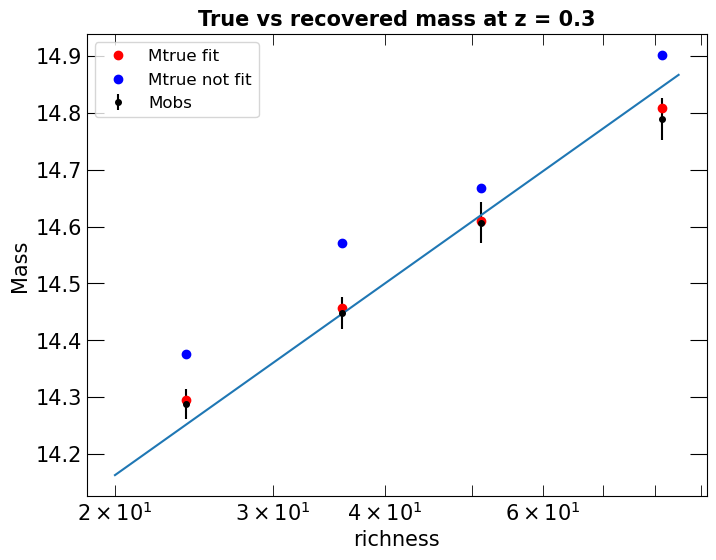

In [16]:
mean_masses_true = np.array([np.log10(mean_mass_true0), np.log10(mean_mass_true1), np.log10(mean_mass_true2), np.log10(mean_mass_true3)]) #new data true_mass*h 
mask = lam_noiseless2 > 20
x = [23.99617, 35.86541, 51.21334, 81.45424]

plt.rcParams['figure.figsize'] = (8,6)
plt.xscale("log")
plt.errorbar(x, Mobs, yerr = std_arr_obs, 
             fmt = 'o', ms = 4.0, color = 'black', 
             label = "Mobs")
plt.plot(x, mean_masses_true, 'or', label = "Mtrue fit")
plt.plot(x, mean_masses_true0, 'ob', label = "Mtrue not fit")
plt.plot(lam_noiseless2[mask], np.log10(avg_M[mask]), '-')
plt.title("True vs recovered mass at z = 0.3", fontsize=15)
plt.xlabel("richness", fontsize=15)
plt.ylabel("Mass", fontsize=15)
plt.legend()
plt.show()

### McClintock Figure 4 (using MiniUchuu data)

In [17]:
# Values taken from McClintock et. al., 2019.
# Boost factors
B_dic = {"l3_z0":0.34, "l4_z0":0.37, "l5_z0":0.27, "l6_z0":0.23, 
         "l3_z1":0.05, "l4_z1":0.14, "l5_z1":0.05, "l6_z1":0.21, 
         "l3_z2":0.13, "l4_z2":0.13, "l5_z2":0.09, "l6_z2":0.04}

# Boost factor scale radius
Rs_dic = {"l3_z0":0.44, "l4_z0":0.50, "l5_z0":0.80, "l6_z0":1.37, 
          "l3_z1":0.89, "l4_z1":0.44, "l5_z1":1.72, "l6_z1":0.51, 
          "l3_z2":0.38, "l4_z2":0.44, "l5_z2":0.85, "l6_z2":35.94}

z_dic = {"0":0.5*(0.2+0.35), "1":0.5*(0.35+0.5), "2":0.5*(0.5+0.65)}
Am_dic = {"0":1.021, "1":1.14, "2":1.16}


Sigma_crit_dic = {"l3_z0":2.558834359999999819e-04, "l4_z0":2.562248809999999950e-04, 
                  "l5_z0":2.559633569999999851e-04, "l6_z0":2.557816409999999962e-04, 
                  "l3_z1":2.631864830000000188e-04, "l4_z1":2.640424589999999859e-04, 
                  "l5_z1":2.630129280000000004e-04, "l6_z1":2.629873459999999808e-04, 
                  "l3_z2":2.376251149999999903e-04, "l4_z2":2.379116389999999873e-04, 
                  "l5_z2":2.372028870000000031e-04, "l6_z2":2.373956570000000036e-04}

mass_dic = {"l3_z0": mean_mass_true0, "l4_z0": mean_mass_true1, "l5_z0": mean_mass_true2, "l6_z0": mean_mass_true3} #3 = 3rd richness bin, in that order.
Sigma_dic = {"l3_z0": Sigma0, "l4_z0": Sigma1, "l5_z0": Sigma2, "l6_z0": Sigma3} #3 = 3rd richness bin, in that order.
DeltaSigma_dic = {"l3_z0": DeltaSigma0, "l4_z0": DeltaSigma1, "l5_z0": DeltaSigma2, "l6_z0": DeltaSigma3} #3 = 3rd richness bin, in that order.

In [18]:
from classy import Class
import cluster_toolkit as ctk
from colossus.cosmology import cosmology
from scipy.stats import norm#, multivariate_normal

#Start by specifying the cosmology
Omega_b = cosmo_params['Ob0']
Omega_m = cosmo_params['Om0']
Omega_cdm = Omega_m - Omega_b
sigma8 = cosmo_params['sigma8']
h = cosmo_params['H0']/100 # McClintock h value
A_s = 2.1e-9 
n_s = cosmo_params['ns']
# z = 0.3

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 1000 #UNITS: 1/Mpc

params = {
         'output':'mPk',
         'h':h,
         'sigma8':sigma8,
         'n_s':n_s,
         'Omega_b':Omega_b,
         'Omega_cdm':Omega_cdm,
         'P_k_max_1/Mpc':k_max,
         'z_max_pk':1.0, #Default value is 10
         'non linear':'halofit'
}

#Initialize the cosmology and compute everything
cosmo_ctk = Class()
cosmo_ctk.set(params)
cosmo_ctk.compute()

In [19]:
rp = np.array([ 0.04221139,  0.06651455,  0.10516441,  0.16537565,  0.26069825, 
               0.41202975,  0.65045543,  1.02563815,  1.61857299,  2.55379112, 
               4.02731114,  6.34991963, 10.00980414, 15.784786  , 24.87216972])
def add_sys_to_data(mass, DS_data08, Sigma_data08, Rs, B0, Am, tau, fmis, c, z, lam, Rp_mid):
    # computing miscentering corrections
    Rlam = (lam/100)**0.2 #Mpc/h comoving
    Rmis = tau*Rlam #Mpc/h Radial miscentering offset. Cluster centers are wrongly identified by a distance Rmis.
    
    # McClintock radial bins
    Rmin = 0.0323
    Rmax = 30
    nbins = 15
    # rp = rp_
    Rproj = rp_
    Redges = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins+1) #Projected radial bin edges
    Redges *= h*(1+z) #Converted to Mpc/h comoving
    
    # DeltaSigma (excess surface density)
    Sigma_mis8  = ctk.miscentering.Sigma_mis_at_R(Rproj, Rproj, Sigma_data08, mass, c, Omega_m, Rmis, kernel="gamma") #miscentered Sigma profiles
    DS_mis8 = ctk.miscentering.DeltaSigma_mis_at_R(Rproj, Rproj, Sigma_mis8) #miscentered Sigma profiles
    full_Sigma = (1-fmis)*Sigma_data08 + fmis*Sigma_mis8 
    
    DS_data8 = (1-fmis)*DS_data08 + fmis*DS_mis8 # miscentered (from theory) + correctly centered DeltaSigma profiles
    DS_data8 *= Am # multiplicative bias

    # Compute boost factors from cluster toolkit
    boost_model = ctk.boostfactors.boost_nfw_at_R(Rproj, B0, Rs*h*(1+z)) # to correct for dilution effects
    DS_data8 /= boost_model # de-boost the model
    Sigma_crit_inv = Sigma_crit_inv0*h*(1+z)**2
    DS_data8 /= (1-full_Sigma*Sigma_crit_inv) #Reduced shear
    DS_data_final = ctk.averaging.average_profile_in_bins(Redges, Rproj, DS_data8)
    DS_data_final *= h*(1+z)**2 #convert to Msun/pc^2 physical
    
    boost_model2 = ctk.boostfactors.boost_nfw_at_R(Rp_mid, B0, Rs) #theory
    
    
    DS_data_final_raw = ctk.averaging.average_profile_in_bins(Redges, Rproj, DS_data08)
    DS_data_final_raw *= h*(1+z)**2 #convert to Msun/pc^2 physical
    return DS_data_final, boost_model2, DS_data_final_raw

[341.76008735 292.26169081 251.292351   210.35051995 158.56070243
 115.97754564  80.4717232   53.14554509  32.26505861  17.06534027
   8.29617022   4.3257844    2.37455595   1.83433191   1.19292103]
[352.03667027 322.0678176  289.69578914 234.39493211 188.4318192
 140.46227174 100.05364571  66.59895355  41.8651781   24.18556002
  11.1327904    5.9052226    3.54326895   2.08647844   1.22170424]
[324.90526756 318.25284325 307.43393001 264.87013119 216.00708426
 159.06854093 120.12654474  82.45281849  55.2877252   31.67547952
  15.99412589   7.71204752   4.23865557   2.41905815   1.72053229]
[494.56684191 447.31007088 422.38197847 349.52694864 282.61318946
 211.75748036 157.91739226 113.67564639  76.05343488  44.77473222
  21.73297365  10.40661807   5.6108389    2.8294192    2.31985852]


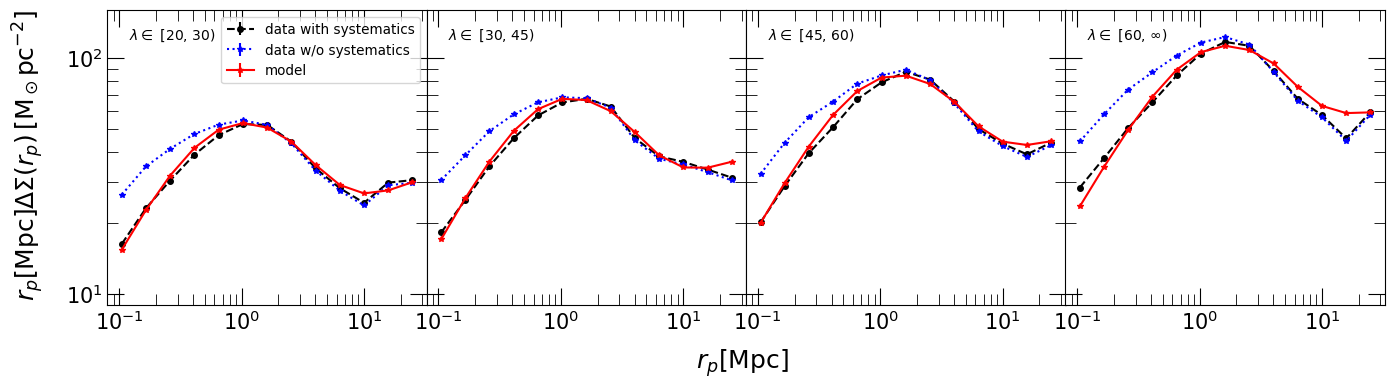

In [20]:
from cluster_toolkit import miscentering
# # Set cosmology
converted_mini_uchuu = {}
saved_profiles_dic = "/global/u2/t/titus/Titus/Lensing/data/saved_mini_uchuu_profiles_newdata_dic_mh_phys_units_raw_no_sys.npy"
lambda_range = ["[20, 30)", "[30, 45)", "[45, 60)", "[60, ∞)"]
z = 0.3
a = 1/(1+z)
a2 = a**2
Am = 1.021 #Am_dic[l3_z0] 

#Specify k and z
k = np.logspace(-5, np.log10(k_max), num=4000) #Mpc^-1 comoving

# Power spectrum
Pnonlin = np.array([cosmo_ctk.pk(ki, z) for ki in k])#*h**3  #Mpc^3/h^3 comoving
Plin = np.array([cosmo_ctk.pk_lin(ki, z) for ki in k])#*h**3  #Mpc^3/h^3 comoving
kh = k/h #h/Mpc comoving

#P(k) are in Mpc^3/h^3 comoving
#Thus, you will need to convert these to h/Mpc and (Mpc/h)^3 to use in the toolkit.
Plin *= h**3
Pnonlin *= h**3

# Create a figure and four subplots (1 row, 4 columns)
drop = 1
fig, axes = plt.subplots(1, 4, figsize=(14, 4), sharey=True, sharex = True)
# files_list = []
for j in range(4):
    if j+3 == 3:
        lam = 25.0
        # lam = 0.5*(20.0+30.0)
    elif j+3 == 4:
        lam = 40.0
        # lam = 0.5*(30.0+45.0)
    elif j+3 == 5:
        lam = 55.0
        # lam = 0.5*(45.0+60.0)
    elif j+3 == 6:
        lam = 82.0

    ########################################### 
    # parameters
    lam_z_bin = "l"+str(j+3)+"_z0"
    mass = mass_dic[lam_z_bin]
    c = concentration.concentration(M=mass, mdef='200m', z=z, model = 'bhattacharya13') # 'bhattacharya13', 'bullock01'
    Rs = Rs_dic[lam_z_bin] #0.44 
    B0 = B_dic[lam_z_bin] #0.34 
    tau = 0.17
    fmis = 0.25
    Sigma_crit_inv0 = Sigma_crit_dic[lam_z_bin] #2.558834359999999819e-04 
    
    # computing miscentering corrections
    Rlam = (lam/100)**0.2 #Mpc/h comoving
    Rmis = tau*Rlam #Mpc/h Radial miscentering offset. Cluster centers are wrongly identified by a distance Rmis.
    # Rproj = rp_
    Rproj = np.logspace(-2, 2.4, num=1000, base=10) #Mpc/h Projected 2D radii. 
    R3d = np.logspace(-2, 3, num=1000, base=10) #Mpc/h comoving. 3D radii.
    
    # rp in comoving Mpc/h
    Rmin = 0.0323 
    Rmax = 30 
    nbins = 15
    
    Redges = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins+1) #Projected radial bin edges
    Redges *= h*(1+z) #Converted to Mpc/h comoving
    
    ##############################
    # Incorporating systematic effects into the simulated profiles
    Sigma_data08 = Sigma_dic[lam_z_bin] # Sigma profile
    DS_data08 = DeltaSigma_dic[lam_z_bin] # DeltaSigma profile
    DS_data8, _, DS_data_final_raw = add_sys_to_data(mass, DS_data08, Sigma_data08, Rs, B0, Am, tau, fmis, c, z, lam, rp)
    
    ##############################
    converted_mini_uchuu[lam_z_bin] = DS_data_final_raw
    
    ##############################
    # Compute boost factors from cluster toolkit
    # NFW profile
    xi_nfw = ctk.xi.xi_nfw_at_r(R3d, mass, c, Omega_m)
    
    # Matter-matter correlation function (matter auto-correlation)
    xi_mm = ctk.xi.xi_mm_at_r(R3d, kh, Pnonlin)
    
     # 2-halo correlation function
    bias_term = ctk.bias.bias_at_M(mass, kh, Plin, Omega_m) # Here, P must be linear.
    xi_2halo = ctk.xi.xi_2halo(bias_term, xi_mm)
    
    # Halo-matter correlation function
    xi_hm = ctk.xi.xi_hm(xi_nfw, xi_2halo)
    
    # Sigma (computed from xi_hm)
    Sigma = ctk.deltasigma.Sigma_at_R(Rproj, R3d, xi_hm, mass, c, Omega_m) #Sigma
    
    # DeltaSigma (excess surface density)
    # mass = mass/h
    DS_theory = ctk.deltasigma.DeltaSigma_at_R(Rproj, Rproj, Sigma, mass, c, Omega_m) #DeltaSigma
    # print(DS_theory)
    Sigma_mis = ctk.miscentering.Sigma_mis_at_R(Rproj, Rproj, Sigma, mass, c, Omega_m, Rmis, kernel="gamma") #miscentered Sigma profiles
    # print(Sigma_mis)
    DS_mis = ctk.miscentering.DeltaSigma_mis_at_R(Rproj, Rproj, Sigma_mis) #miscentered Sigma profiles
    # print(DS_mis)
    #full Sigma profile; i.e. miscentered + correctly centered Sigma profiles
    full_Sigma = (1-fmis)*Sigma + fmis*Sigma_mis 
    #full DeltaSigma profile; i.e. miscentered + correctly centered DeltaSigma profiles
    full_DS = (1-fmis)*DS_theory + fmis*DS_mis 
    full_DS *= Am #multiplicative bias
    
    # Compute boost factors from cluster toolkit
    #Note: Rs is default in Mpc physical
    boost_model = ctk.boostfactors.boost_nfw_at_R(Rproj, B0, Rs*h*(1+z)) #theory

    full_DS /= boost_model #de-boost the model
    Sigma_crit_inv = Sigma_crit_inv0*h*(1+z)**2
    #Here, DeltaSigma is in Msun h/pc^2 comoving
    full_DS /= (1-full_Sigma*Sigma_crit_inv) #Reduced shear

    ave_DS = ctk.averaging.average_profile_in_bins(Redges, Rproj, full_DS)
    ave_DS *= h*(1+z)**2 #convert to Msun/pc^2 physical

    print(DS_data_final_raw)
    inds = (rp > 0.1)*(rp < 999) 
    rp2 = rp[inds]
    
    label = ["data with systematics", "data w/o systematics", "model"]
    axes[j].loglog()

    ########################
    axes[j].set_ylim(9.0, 1.6e2)
    # axes[j].set_ylim(0.4, 3.5e2)
    axes[j].errorbar(rp2, rp2*DS_data8[inds], yerr = np.zeros(len(rp2)), 
                     fmt = '--o', ms = 4.0, color = 'black', label = label[0])
    axes[j].errorbar(rp2, rp2*DS_data_final_raw[inds], yerr = np.zeros(len(rp2)), 
                     fmt = ':*', ms = 4.0, color = 'blue', label = label[1]) #:*, -.*, --*, -*
    axes[j].errorbar(rp2, rp2*ave_DS[inds], yerr = np.zeros(len(rp2)), 
                     fmt = '-*', ms = 4.0, color = 'red', label = label[2])
    axes[j].text(0.120, 120.0, f"$\lambda \in$ {lambda_range[j]}", fontsize = 10)
    if j == 0:
        axes[j].legend(fontsize=9.8)
        
# Add a super title, super x label, and super y label
# fig.suptitle(r'$\Delta\Sigma$ Profiles', fontsize=20)
fig.supxlabel(r"$\rm \mathit{r_p} [Mpc]$", x = 0.53, y = 0.08, va='center', ha='center', fontsize=18)
fig.supylabel(r"$\rm \mathit{r_p} [Mpc] \Delta\Sigma(\mathit{r_p})\,[M_\odot \mathrm{pc}^{-2}]$", x = 0.02, y = 0.6, va='center', ha='center', fontsize=18)

# Adjust spacing between subplots
plt.tight_layout(h_pad = -1.0, w_pad = -1.15)
plt.show()

# np.save(saved_profiles_dic, converted_mini_uchuu)

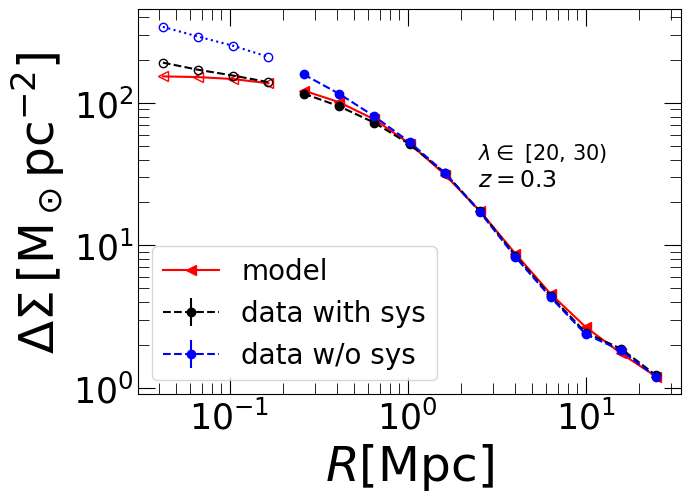

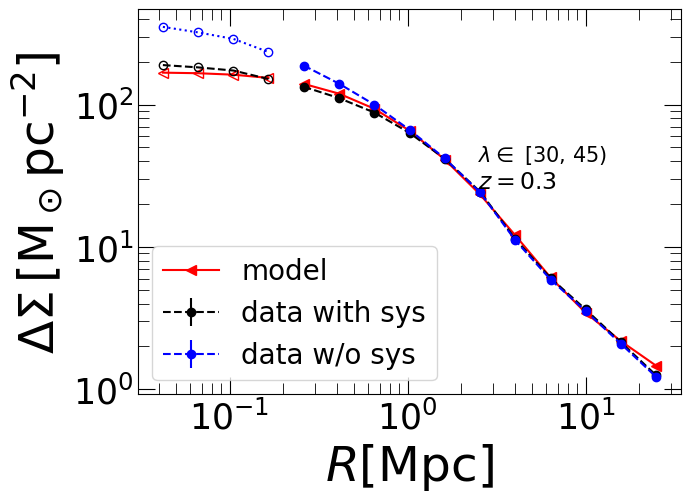

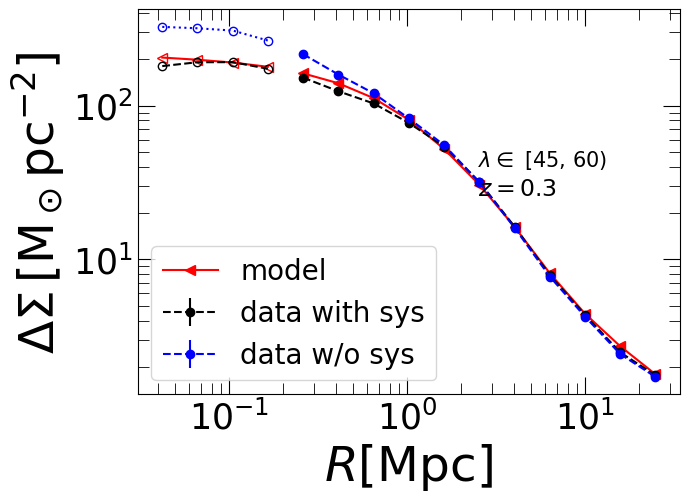

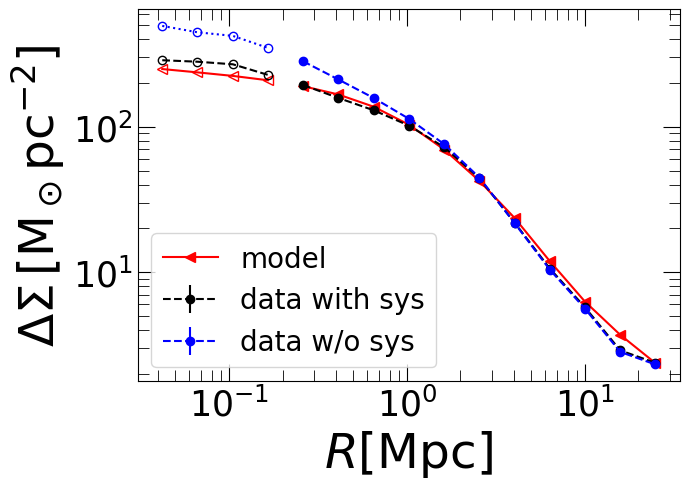

In [21]:
from cluster_toolkit import miscentering
# Set cosmology
converted_mini_uchuu = {}
saved_profiles_dic = "/global/u2/t/titus/Titus/Lensing/data/saved_mini_uchuu_profiles_newdata_dic_mh_phys_units_raw_no_sys.npy"
lambda_range = ["[20, 30)", "[30, 45)", "[45, 60)", "[60, ∞)"]
z = 0.3
a = 1/(1+z)
a2 = a**2
Am = 1.021 

#Specify k and z
k = np.logspace(-5, np.log10(k_max), num=4000) #Mpc^-1 comoving

# Power spectrum
Pnonlin = np.array([cosmo_ctk.pk(ki, z) for ki in k])#*h**3  #Mpc^3/h^3 comoving
Plin = np.array([cosmo_ctk.pk_lin(ki, z) for ki in k])#*h**3  #Mpc^3/h^3 comoving
kh = k/h #h/Mpc comoving

#P(k) are in Mpc^3/h^3 comoving
#Thus, you will need to convert these to h/Mpc and (Mpc/h)^3 to use in the toolkit.
Plin *= h**3
Pnonlin *= h**3

# Create a figure and four subplots (1 row, 4 columns)
drop = 1
# files_list = []
for j in range(4):
    if j+3 == 3:
        lam = 25.0
        # lam = 0.5*(20.0+30.0)
    elif j+3 == 4:
        lam = 40.0
        # lam = 0.5*(30.0+45.0)
    elif j+3 == 5:
        lam = 55.0
        # lam = 0.5*(45.0+60.0)
    elif j+3 == 6:
        lam = 82.0

    ########################################### 
    # parameters
    lam_z_bin = "l"+str(j+3)+"_z0"
    mass = mass_dic[lam_z_bin]
    c = concentration.concentration(M=mass, mdef='200m', z=z, model = 'bhattacharya13') # 'bhattacharya13', 'bullock01'
    Rs = Rs_dic[lam_z_bin] #0.44 
    B0 = B_dic[lam_z_bin] #0.34 
    tau = 0.17
    fmis = 0.25
    Sigma_crit_inv0 = Sigma_crit_dic[lam_z_bin] #2.558834359999999819e-04 
    
    # computing miscentering corrections
    Rlam = (lam/100)**0.2 #Mpc/h comoving
    Rmis = tau*Rlam #Mpc/h Radial miscentering offset. Cluster centers are wrongly identified by a distance Rmis.
    Rproj = np.logspace(-2, 2.4, num=1000, base=10) #Mpc/h Projected 2D radii. 
    R3d = np.logspace(-2, 3, num=1000, base=10) #Mpc/h comoving. 3D radii.
    
    # rp in comoving Mpc/h
    Rmin = 0.0323 
    Rmax = 30 
    nbins = 15
    
    Redges = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins+1) #Projected radial bin edges
    Redges *= h*(1+z) #Converted to Mpc/h comoving
    
    ##############################
    # Incorporating systematic effects into the simulated profiles
    Sigma_data08 = Sigma_dic[lam_z_bin] # Sigma profile
    DS_data08 = DeltaSigma_dic[lam_z_bin] # DeltaSigma profile
    DS_data8, _, DS_data_final_raw = add_sys_to_data(mass, DS_data08, Sigma_data08, Rs, B0, Am, tau, fmis, c, z, lam, rp)
    
    ##############################
    converted_mini_uchuu[lam_z_bin] = DS_data_final_raw
   
    ##############################
    # NFW profile
    xi_nfw = ctk.xi.xi_nfw_at_r(R3d, mass, c, Omega_m)
    
    # Matter-matter correlation function (matter auto-correlation)
    xi_mm = ctk.xi.xi_mm_at_r(R3d, kh, Pnonlin)
    
     # 2-halo correlation function
    bias_term = ctk.bias.bias_at_M(mass, kh, Plin, Omega_m) # Here, P must be linear.
    xi_2halo = ctk.xi.xi_2halo(bias_term, xi_mm)
    
    # Halo-matter correlation function
    xi_hm = ctk.xi.xi_hm(xi_nfw, xi_2halo)
    
    # Sigma (computed from xi_hm)
    Sigma = ctk.deltasigma.Sigma_at_R(Rproj, R3d, xi_hm, mass, c, Omega_m) #Sigma
    
    # DeltaSigma (excess surface density)
    # mass = mass/h
    DS_theory = ctk.deltasigma.DeltaSigma_at_R(Rproj, Rproj, Sigma, mass, c, Omega_m) #DeltaSigma
    Sigma_mis = ctk.miscentering.Sigma_mis_at_R(Rproj, Rproj, Sigma, mass, c, Omega_m, Rmis, kernel="gamma") #miscentered Sigma profiles
    DS_mis = ctk.miscentering.DeltaSigma_mis_at_R(Rproj, Rproj, Sigma_mis) #miscentered Sigma profiles
    full_Sigma = (1-fmis)*Sigma + fmis*Sigma_mis 
    full_DS = (1-fmis)*DS_theory + fmis*DS_mis 
    full_DS *= Am #multiplicative bias
    
    # Compute boost factors from cluster toolkit
    #Note: Rs is default in Mpc physical
    boost_model = ctk.boostfactors.boost_nfw_at_R(Rproj, B0, Rs*h*(1+z)) #theory

    full_DS /= boost_model #de-boost the model
    Sigma_crit_inv = Sigma_crit_inv0*h*(1+z)**2
    #Here, DeltaSigma is in Msun h/pc^2 comoving
    full_DS /= (1-full_Sigma*Sigma_crit_inv) #Reduced shear

    ave_DS = ctk.averaging.average_profile_in_bins(Redges, Rproj, full_DS)
    ave_DS *= h*(1+z)**2 #convert to Msun/pc^2 physical

    inds = (rp >= 0.20)*(rp < 999) 
    inds2 = (rp > 0.0)*(rp < 0.2) 
    # inds = rp > 0.0
    rp1 = rp[inds]
    rp2 = rp[inds2]
    
    fig, axes = plt.subplots(1, 1, figsize=(7, 5), sharey=True, sharex = True)
    axes.loglog()

    ########################
    axes.errorbar(rp2, DS_data8[inds2], yerr = np.zeros(len(rp2)), fmt = '--o', 
                  ms = 6.0, color = 'black', fillstyle='none')
    axes.errorbar(rp1, DS_data8[inds], yerr = np.zeros(len(rp1)), fmt = '--o', 
                  ms = 6.0, color = 'black', label = "data with sys")
    
    axes.errorbar(rp2, DS_data_final_raw[inds2], yerr = np.zeros(len(rp2)), fmt = ':o', 
                  ms = 6.0, color = 'blue', fillstyle='none')
    axes.errorbar(rp1, DS_data_final_raw[inds], yerr = np.zeros(len(rp1)), fmt = '--o', 
                  ms = 6.0, color = 'blue', label = "data w/o sys")
    
    axes.plot(rp2, ave_DS[inds2], "-r", marker='<', ms = 7.0, fillstyle='none')
    axes.plot(rp1, ave_DS[inds], "-r", marker='<', ms = 7.0, label = "model")
    axes.set_xlabel(r"$\rm \mathit{R} [\mathrm{Mpc}]$", fontsize=35)
    axes.set_ylabel(r"$\rm \Delta\Sigma\,[M_\odot \mathrm{pc}^{-2}]$", fontsize=35)
    if j == 3:
        pass
    else:
        axes.text(2.5, 40.0, f"$\lambda \in$ {lambda_range[j]}", fontsize = 15)
        axes.text(2.5, 26.0, f"$z = 0.3$", fontsize = 17)
    axes.tick_params(axis='both', which='major', labelsize=25)  # Adjusting both axes, major ticks
    axes.legend(fontsize = 20)

# Adjust spacing between subplots
plt.tight_layout(h_pad = 0.0, w_pad = 0.2)
plt.show()

# np.save(saved_profiles_dic, converted_mini_uchuu)

### Varying concentration

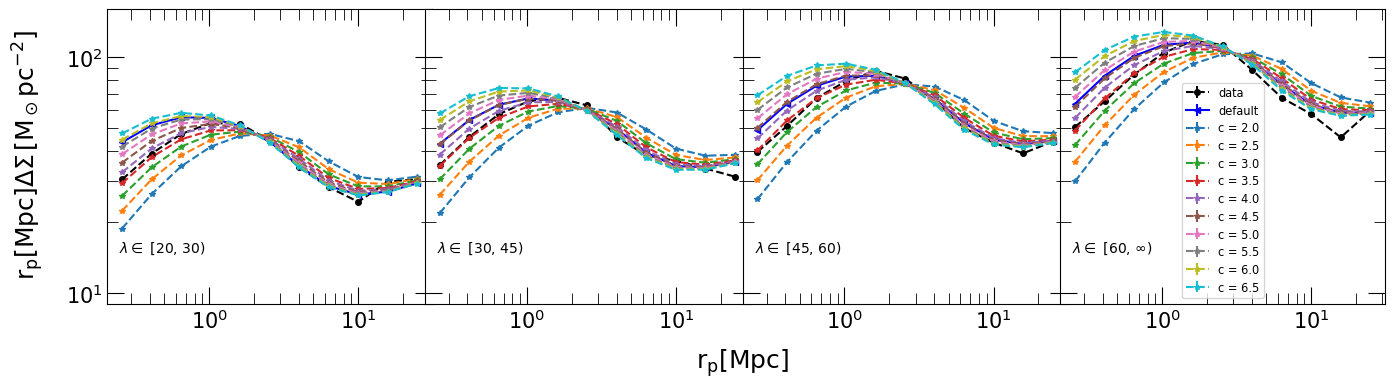

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

lambda_range = ["[20, 30)", "[30, 45)", "[45, 60)", "[60, ∞)"]
nbody_loc = '/global/u2/t/titus/Titus/Lensing/data/'

cyl_depth = 30
ds_data = np.load(nbody_loc+"saved_mini_uchuu_profiles_newdata_dic_mh_phys_units_final22.npy", allow_pickle=True).item()
ds_models = np.load(nbody_loc+"saved_mini_uchuu_profiles_no_sys_model_phys_units_final2.npy", allow_pickle=True).item()
ds0 = np.load(nbody_loc+"saved_mini_uchuu_profiles_no_sys_model_phys_units_final_c_2.0.npy", allow_pickle=True).item()
ds1 = np.load(nbody_loc+"saved_mini_uchuu_profiles_no_sys_model_phys_units_final_c_2.5.npy", allow_pickle=True).item()
ds2 = np.load(nbody_loc+"saved_mini_uchuu_profiles_no_sys_model_phys_units_final_c_3.0.npy", allow_pickle=True).item()
ds3 = np.load(nbody_loc+"saved_mini_uchuu_profiles_no_sys_model_phys_units_final_c_3.50.npy", allow_pickle=True).item()
ds4 = np.load(nbody_loc+"saved_mini_uchuu_profiles_no_sys_model_phys_units_final_c_4.0.npy", allow_pickle=True).item()
ds5 = np.load(nbody_loc+"saved_mini_uchuu_profiles_no_sys_model_phys_units_final_c_4.5.npy", allow_pickle=True).item()
ds6 = np.load(nbody_loc+"saved_mini_uchuu_profiles_no_sys_model_phys_units_final_c_5.0.npy", allow_pickle=True).item()
ds7 = np.load(nbody_loc+"saved_mini_uchuu_profiles_no_sys_model_phys_units_final_c_5.50.npy", allow_pickle=True).item()
ds8 = np.load(nbody_loc+"saved_mini_uchuu_profiles_no_sys_model_phys_units_final_c_6.0.npy", allow_pickle=True).item()
ds9 = np.load(nbody_loc+"saved_mini_uchuu_profiles_no_sys_model_phys_units_final_c_6.5.npy", allow_pickle=True).item()

con = [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5]
rp = np.array([0.04221139,  0.06651455,  0.10516441,  0.16537565,  0.26069825, 
               0.41202975,  0.65045543,  1.02563815,  1.61857299,  2.55379112, 
               4.02731114,  6.34991963, 10.00980414, 15.784786  , 24.87216972])
inds = (rp > 0.2)*(rp < 999) 
rp2 = rp[inds]

# Create a figure and four subplots (1 row, 4 columns)
drop = 1
fig, axes = plt.subplots(1, 4, figsize=(14, 4), sharey=True, sharex = True)

for j in range(4):
    lam_z_bin = "l"+str(j+3)+"_z0"
    ds_data0 = ds_data[lam_z_bin]
    ds_models0 = ds_models[lam_z_bin]
    ds00 = ds0[lam_z_bin]
    ds11 = ds1[lam_z_bin]
    ds22 = ds2[lam_z_bin]
    ds33 = ds3[lam_z_bin]
    ds44 = ds4[lam_z_bin]
    ds55 = ds5[lam_z_bin]
    ds66 = ds6[lam_z_bin]
    ds77 = ds7[lam_z_bin]
    ds88 = ds8[lam_z_bin]
    ds99 = ds9[lam_z_bin]
    
    lensing_profile = [ds00, ds11, ds22, ds33, ds44, ds55, ds66, ds77, ds88, ds99]
    
    label = ["data", "default"]
    axes[j].loglog()
    axes[j].set_ylim(9.0, 1.6e2)
    axes[j].errorbar(rp2, rp2*ds_data0[inds], yerr = np.zeros(len(rp2)), 
                     fmt = '--o', ms = 4.0, color = 'black', label = label[0])
    axes[j].errorbar(rp2, rp2*ds_models0[inds], yerr = np.zeros(len(rp2)), 
                     fmt = '-<', ms = 4.0, color = 'blue', label = label[1]) #:*, -.*, --*, -*
    k = -1
    for profile in lensing_profile:
        ########################
        k += 1
        axes[j].errorbar(rp2, rp2*profile[inds], yerr = np.zeros(len(rp2)), 
                         fmt = '--', marker='*', ms = 4.0, label = f"c = {con[k]}") #:*, -.*, --*, -*
    axes[j].text(0.250, 15.0, f"$\lambda \in$ {lambda_range[j]}", fontsize = 10)
    if j == 3:
        axes[j].legend(fontsize=8.2)
        
# Add a super title, super x label, and super y label
fig.supxlabel(r"$\rm r_p [\mathrm{Mpc}]$", x = 0.53, y = 0.08, va='center', ha='center', fontsize=18)
fig.supylabel(r"$\rm r_p [\mathrm{Mpc}] \Delta\Sigma\,[M_\odot \mathrm{pc}^{-2}]$", x = 0.02, y = 0.6, va='center', ha='center', fontsize=18)

# Adjust spacing between subplots
plt.tight_layout(h_pad = -1.0, w_pad = -0.50)
plt.show()
